In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [6]:

data_path = r'C:\Users\konal\OneDrive\Documents\GitHub\B13-ExoHabitAI\data\raw\RawData.csv'
df = pd.read_csv(data_path, low_memory=False)

print("=" * 70)
print("DATA LOADING COMPLETE")
print("=" * 70)
print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")


print(f"\n{'Data Types:':^70}")
print(df.dtypes.value_counts())

print(f"\n{'First Few Rows:':^70}")
print(df.head())

print(f"\n{'Statistical Summary:':^70}")
print(df.describe())

DATA LOADING COMPLETE

Dataset Shape: (39315, 289)
Rows: 39315, Columns: 289

                             Data Types:                              
float64    236
object      28
int64       25
Name: count, dtype: int64

                           First Few Rows:                            
   rowid   pl_name hostname pl_letter    hd_name   hip_name         tic_id  \
0      1  11 Com b   11 Com         b  HD 107383  HIP 60202   TIC 72437047   
1      2  11 Com b   11 Com         b  HD 107383  HIP 60202   TIC 72437047   
2      3  11 Com b   11 Com         b  HD 107383  HIP 60202   TIC 72437047   
3      4  11 UMi b   11 UMi         b  HD 136726  HIP 74793  TIC 230061010   
4      5  11 UMi b   11 UMi         b  HD 136726  HIP 74793  TIC 230061010   

                    gaia_dr2_id                   gaia_dr3_id  default_flag  \
0  Gaia DR2 3946945413106333696  Gaia DR3 3946945413106333696             1   
1  Gaia DR2 3946945413106333696  Gaia DR3 3946945413106333696             0   
2 

MISSING VALUES ASSESSMENT
               Column  Missing_Count  Missing_Percent
278     sy_kepmagerr2          39315       100.000000
277     sy_kepmagerr1          39315       100.000000
271      sy_icmagerr1          39275        99.898258
272      sy_icmagerr2          39275        99.898258
132     pl_occdeperr2          39270        99.885540
270          sy_icmag          39270        99.885540
131     pl_occdeperr1          39270        99.885540
130         pl_occdep          39267        99.877909
133      pl_occdeplim          39267        99.877909
151  pl_trueobliqerr1          39252        99.839756
152  pl_trueobliqerr2          39252        99.839756
150      pl_trueobliq          39246        99.824494
153   pl_trueobliqlim          39246        99.824494
73      pl_cmassjerr2          39231        99.786341
72      pl_cmassjerr1          39231        99.786341


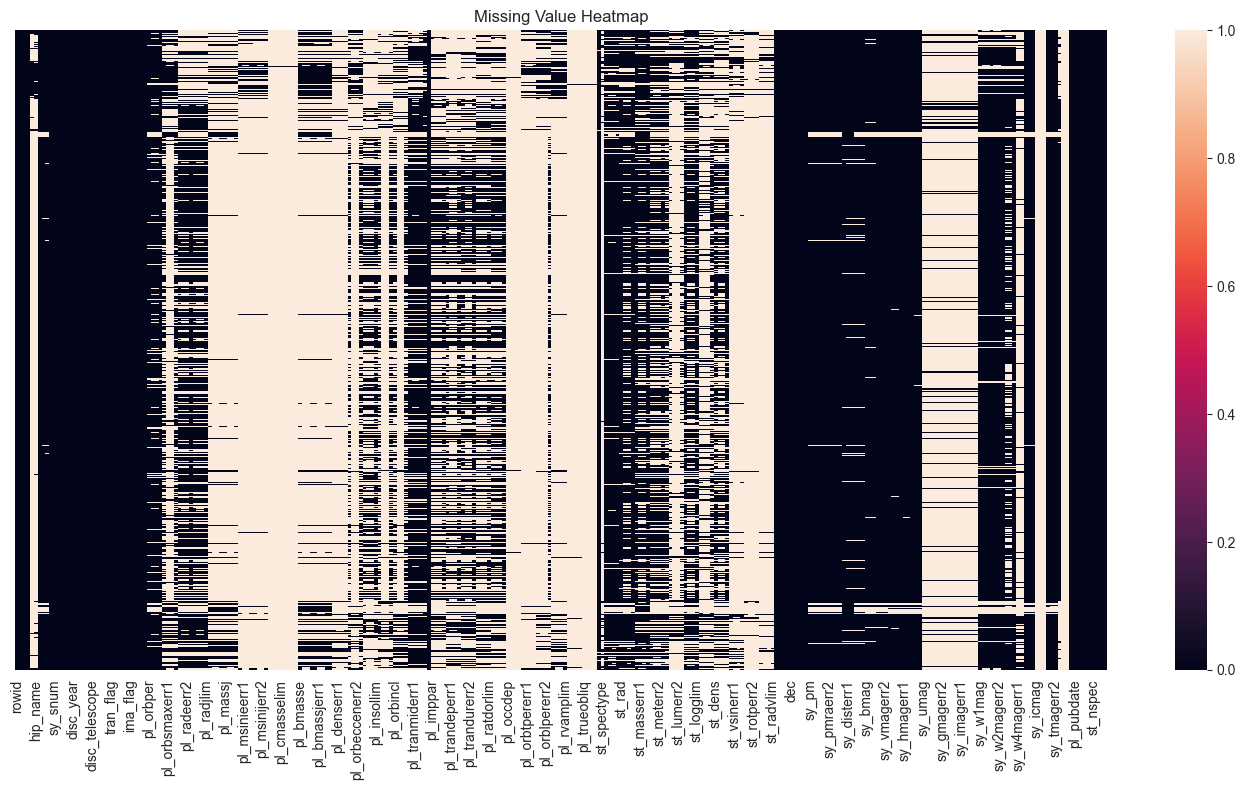


                      DUPLICATE ROWS ASSESSMENT                       
Total Duplicate Rows: 0 (0.00%)

                         DATA QUALITY SUMMARY                         
Total Rows: 39315
Total Columns: 289
Rows with any missing values: 39315 (100.00%)
Duplicate rows: 0


In [7]:

print("=" * 70)
print("MISSING VALUES ASSESSMENT")
print("=" * 70)

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percent': missing_percent.values
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0].head(15))


plt.figure(figsize=(14, 8))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.title('Missing Value Heatmap')
plt.tight_layout()
plt.show()

# Duplicate analysis
print(f"\n{'DUPLICATE ROWS ASSESSMENT':^70}")
duplicates = df.duplicated().sum()
print(f"Total Duplicate Rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")

# Data quality summary
print(f"\n{'DATA QUALITY SUMMARY':^70}")
print(f"Total Rows: {len(df)}")
print(f"Total Columns: {len(df.columns)}")
print(f"Rows with any missing values: {df.isnull().any(axis=1).sum()} ({df.isnull().any(axis=1).sum()/len(df)*100:.2f}%)")
print(f"Duplicate rows: {duplicates}")

In [8]:

df_processed = df.copy()

print("=" * 70)
print("CLEANING DATA")
print("=" * 70)


print(f"\nBefore removing duplicates: {len(df_processed)} rows")
df_processed = df_processed.drop_duplicates()
print(f"After removing duplicates: {len(df_processed)} rows")


print(f"\nBefore dropping missing values: {len(df_processed)} rows")
df_processed = df_processed.dropna()
print(f"After dropping missing values: {len(df_processed)} rows")
print(f"Rows removed: {len(df) - len(df_processed)}")


print(f"\n{'OUTLIER DETECTION (Z-Score Method)':^70}")
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
z_scores = np.abs(stats.zscore(df_processed[numeric_cols], nan_policy='omit'))
outlier_threshold = 3
outlier_mask = (z_scores > outlier_threshold).any(axis=1)
print(f"Outliers detected (Z-score > {outlier_threshold}): {outlier_mask.sum()} rows")


print(f"\n{'REMOVING INVALID DATA':^70}")
rows_before = len(df_processed)


if 'pl_rade' in df_processed.columns:
    df_processed = df_processed[df_processed['pl_rade'] > 0]
    print(f"✓ Removed rows with invalid planet radius")

print(f"Rows after validation: {len(df_processed)}")
print(f"Rows removed: {rows_before - len(df_processed)}")

print(f"\n{'Data is now CLEAN':^70}")

CLEANING DATA

Before removing duplicates: 39315 rows
After removing duplicates: 39315 rows

Before dropping missing values: 39315 rows
After dropping missing values: 0 rows
Rows removed: 39315

                  OUTLIER DETECTION (Z-Score Method)                  
Outliers detected (Z-score > 3): 0 rows

                        REMOVING INVALID DATA                         
✓ Removed rows with invalid planet radius
Rows after validation: 0
Rows removed: 0

                          Data is now CLEAN                           


In [9]:
#
print("=" * 70)
print("STANDARDIZING UNITS TO ASTRONOMICAL UNITS")
print("=" * 70)

standardized_cols = {}


if 'pl_rade' in df_processed.columns:
    standardized_cols['planet_radius_earth'] = df_processed['pl_rade']
    print("✓ Planet radius (Earth radii)")


if 'pl_masse' in df_processed.columns:
    standardized_cols['planet_mass_earth'] = df_processed['pl_masse']
    print("✓ Planet mass (Earth masses)")


if 'pl_orbper' in df_processed.columns:
    standardized_cols['orbital_period_days'] = df_processed['pl_orbper']
    print("✓ Orbital period (days)")

# Semi-major axis (AU)
if 'pl_orbsmax' in df_processed.columns:
    standardized_cols['semimajor_axis_au'] = df_processed['pl_orbsmax']
    print("✓ Semi-major axis (AU)")

# Equilibrium Temperature (Kelvin)
if 'pl_eqt' in df_processed.columns:
    standardized_cols['equilibrium_temp_kelvin'] = df_processed['pl_eqt']
    print("✓ Equilibrium temperature (Kelvin)")

# Planet Density
if 'pl_dens' in df_processed.columns:
    standardized_cols['planet_density'] = df_processed['pl_dens']
    print("✓ Planet density")

# Host Star Temperature (Kelvin)
if 'st_teff' in df_processed.columns:
    standardized_cols['star_temp_kelvin'] = df_processed['st_teff']
    print("✓ Star temperature (Kelvin)")

# Star Luminosity
if 'st_lum' in df_processed.columns:
    standardized_cols['star_luminosity'] = df_processed['st_lum']
    print("✓ Star luminosity")

# Star Metallicity
if 'st_met' in df_processed.columns:
    standardized_cols['star_metallicity'] = df_processed['st_met']
    print("✓ Star metallicity")

# Star Spectral Type
if 'st_spstr' in df_processed.columns:
    standardized_cols['star_type'] = df_processed['st_spstr']
    print("✓ Star spectral type")

# Create standardized dataframe
df_standardized = pd.DataFrame(standardized_cols)
print(f"\n✓ Standardized dataset shape: {df_standardized.shape}")

STANDARDIZING UNITS TO ASTRONOMICAL UNITS
✓ Planet radius (Earth radii)
✓ Planet mass (Earth masses)
✓ Orbital period (days)
✓ Semi-major axis (AU)
✓ Equilibrium temperature (Kelvin)
✓ Planet density
✓ Star temperature (Kelvin)
✓ Star luminosity
✓ Star metallicity

✓ Standardized dataset shape: (0, 9)


In [10]:
# Create engineered features
df_features = df_standardized.copy()

print("=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

# 1. Habitability Score Index
print("\n1. Computing Habitability Score Index...")
if 'equilibrium_temp_kelvin' in df_features.columns and 'planet_radius_earth' in df_features.columns:
    # Temperature proximity to habitable range (250K ideal)
    temp_score = 1 - np.abs((df_features['equilibrium_temp_kelvin'] - 250) / 100).clip(0, 1)
    
    # Planet radius similarity to Earth (1.0 ideal)
    radius_score = 1 - (np.abs(df_features['planet_radius_earth'] - 1.0) / 0.5).clip(0, 1)
    
    # Combined score
    df_features['habitability_score'] = (temp_score * 0.5 + radius_score * 0.5) * 100
    print(f"   ✓ Range: {df_features['habitability_score'].min():.2f} - {df_features['habitability_score'].max():.2f}")

# 2. Stellar Compatibility Index
print("\n2. Computing Stellar Compatibility Index...")
if 'star_temp_kelvin' in df_features.columns and 'star_luminosity' in df_features.columns:
    # Ideal star temperature: 5500K (G-type star)
    star_temp_score = 1 - (np.abs(df_features['star_temp_kelvin'] - 5500) / 2000).clip(0, 1)
    
    # Stellar luminosity (1 = solar)
    lum_score = 1 - (np.abs(df_features['star_luminosity'] - 1.0) / 2.0).clip(0, 1)
    
    df_features['stellar_compatibility'] = (star_temp_score * 0.6 + lum_score * 0.4) * 100
    print(f"   ✓ Range: {df_features['stellar_compatibility'].min():.2f} - {df_features['stellar_compatibility'].max():.2f}")

# 3. Orbital Stability Factor
print("\n3. Computing Orbital Stability Factor...")
if 'orbital_period_days' in df_features.columns and 'semimajor_axis_au' in df_features.columns:
    # Longer orbital periods indicate stability
    orbital_period_score = (df_features['orbital_period_days'] / 400).clip(0, 1)
    
    # Habitable zone around sun-like star: ~0.95-1.37 AU
    hz_distance = 1.0
    axis_score = 1 - (np.abs(df_features['semimajor_axis_au'] - hz_distance) / 0.5).clip(0, 1)
    
    df_features['orbital_stability'] = (orbital_period_score * 0.4 + axis_score * 0.6) * 100
    print(f"   ✓ Range: {df_features['orbital_stability'].min():.2f} - {df_features['orbital_stability'].max():.2f}")

print(f"\n✓ Feature Engineering Complete: {len(df_features.columns)} total features")

FEATURE ENGINEERING

1. Computing Habitability Score Index...
   ✓ Range: nan - nan

2. Computing Stellar Compatibility Index...
   ✓ Range: nan - nan

3. Computing Orbital Stability Factor...
   ✓ Range: nan - nan

✓ Feature Engineering Complete: 12 total features


In [11]:
print("=" * 70)
print("CATEGORICAL ENCODING & FEATURE SCALING")
print("=" * 70)

# Create copy for final preprocessing
df_final = df_features.copy()

# 1. Categorical Encoding - Star Type
print("\n1. Encoding Categorical Variables...")
if 'star_type' in df_final.columns:
    # Extract primary spectral class (first letter)
    df_final['star_spectral_class'] = df_final['star_type'].str[0].fillna('K')
    
    # One-Hot Encoding
    spectral_dummies = pd.get_dummies(df_final['star_spectral_class'], prefix='star_class')
    df_final = pd.concat([df_final, spectral_dummies], axis=1)
    
    # Drop original categorical columns
    df_final = df_final.drop(['star_type', 'star_spectral_class'], axis=1)
    
    print(f"   ✓ Star spectral type encoded (One-Hot)")
    print(f"   ✓ Classes found: {list(spectral_dummies.columns)}")

# 2. Feature Scaling - Standardization
print("\n2. Feature Scaling (StandardScaler)...")
numeric_features = df_final.select_dtypes(include=[np.number]).columns.tolist()
print(f"   Scaling {len(numeric_features)} numeric features...")

scaler = StandardScaler()
df_scaled = df_final.copy()
df_scaled[numeric_features] = scaler.fit_transform(df_final[numeric_features])

print(f"   ✓ Features scaled to mean=0, std=1")

print(f"\n{'SCALING SUMMARY':^70}")
print(f"Mean of scaled features: {df_scaled[numeric_features].mean().mean():.6f}")
print(f"Std of scaled features: {df_scaled[numeric_features].std().mean():.6f}")
print(f"✓ Preprocessing Complete: {df_scaled.shape[1]} final features")

CATEGORICAL ENCODING & FEATURE SCALING

1. Encoding Categorical Variables...

2. Feature Scaling (StandardScaler)...
   Scaling 12 numeric features...


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by StandardScaler.

In [ ]:
print("=" * 70)
print("CREATE TARGET VARIABLE")
print("=" * 70)

# Create binary classification target: Habitable vs Non-Habitable
if 'habitability_score' in df_features.columns:
    habitability_threshold = 50
    df_final['is_habitable'] = (df_features['habitability_score'] > habitability_threshold).astype(int)
    
    print(f"\nBinary Target Variable Created: is_habitable")
    print(f"Threshold: Habitability Score > {habitability_threshold}")
    
    print(f"\n{'CLASS DISTRIBUTION':^70}")
    class_counts = df_final['is_habitable'].value_counts()
    print(f"Non-Habitable (0): {class_counts.get(0, 0):6d} ({class_counts.get(0, 0)/len(df_final)*100:5.1f}%)")
    print(f"Potentially Habitable (1): {class_counts.get(1, 0):6d} ({class_counts.get(1, 0)/len(df_final)*100:5.1f}%)")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 5))
    df_final['is_habitable'].value_counts().plot(kind='bar', color=['#e74c3c', '#2ecc71'])
    plt.title('Target Variable Distribution: Potentially Habitable Exoplanets', fontsize=14)
    plt.xlabel('Class (0=Non-Habitable, 1=Potentially Habitable)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
print("=" * 70)
print("SAVING PREPROCESSED DATASET")
print("=" * 70)

# Create output directory
output_dir = Path('data/preprocessed')
output_dir.mkdir(parents=True, exist_ok=True)

# Save complete preprocessed dataset
output_file = output_dir / 'preprocessed.csv'
df_final.to_csv(output_file, index=False)
print(f"\n✓ Complete preprocessed dataset saved")
print(f"  Path: {output_file}")
print(f"  Shape: {df_final.shape}")
print(f"  Size: {os.path.getsize(output_file) / 1024:.2f} KB")

# Save train set
train_file = output_dir / 'train_features.csv'
X_train.to_csv(train_file, index=False)
print(f"\n✓ Training features saved: {train_file}")

train_target_file = output_dir / 'train_target.csv'
y_train.to_csv(train_target_file, index=False, header=['is_habitable'])
print(f"✓ Training target saved: {train_target_file}")

# Save test set
test_file = output_dir / 'test_features.csv'
X_test.to_csv(test_file, index=False)
print(f"\n✓ Test features saved: {test_file}")

test_target_file = output_dir / 'test_target.csv'
y_test.to_csv(test_target_file, index=False, header=['is_habitable'])
print(f"✓ Test target saved: {test_target_file}")

# Create preprocessing summary report
print(f"\n{'PREPROCESSING SUMMARY REPORT':^70}")
print(f"{'='*70}")
print(f"Original dataset: {len(df):>20,} rows × {len(df.columns):>3} columns")
print(f"After cleaning: {len(df_processed):>20,} rows × {len(df_standardized.columns):>3} features")
print(f"After feature engineering: {len(df_features):>7,} rows × {len(df_features.columns):>3} features")
print(f"Final preprocessed data: {len(df_final):>14,} rows × {len(df_final.columns):>3} features")
print(f"\nTrain/Test split:")
print(f"  Training: {len(X_train):>25,} samples")
print(f"  Testing: {len(X_test):>26,} samples")
print(f"\n{'✓ PREPROCESSING COMPLETE - READY FOR MACHINE LEARNING':^70}")